In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from cuml import LogisticRegression as cuMLLogisticRegression
import cudf
from sklearn.metrics import mean_absolute_error, accuracy_score
import joblib

In [2]:
# Veri yükleme (örnek dosya adı ve formatı)
try:
    data = pd.read_csv('/kaggle/input/bitirme-final/veriseti_2.csv')  
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# Veri yapısını kontrol etme
print("Veri setinin ilk 5 satırı:")
print(data.head())
print("\nVeri setinin sütunları:")
print(data.columns)


Veri setinin ilk 5 satırı:
           Fp1           AF7           AF3           F1           F3  \
0 -9562.203435 -10756.709934  17541.906479 -1057.336152 -2906.280485   
1 -9563.985198 -10760.392141  17541.906479 -1057.745253 -2905.251668   
2 -9564.876079 -10762.735364  17541.365875 -1057.898665 -2905.663195   
3 -9563.985198 -10760.057395  17541.906479 -1058.000940 -2906.692012   
4 -9562.797356 -10758.048918  17543.528294 -1056.466814 -2906.897776   

            F5            F7           FT7         FC5          FC3  ...  \
0 -2312.154431  18179.809091  25170.341698  684.393532 -7200.448332  ...   
1 -2311.453383  18178.096364  25169.561132  683.386368 -7201.662607  ...   
2 -2311.920748  18176.954545  25168.780566  681.472756 -7201.662607  ...   
3 -2311.842854  18179.238182  25170.341698  683.537442 -7199.719768  ...   
4 -2311.297595  18180.380000  25170.341698  685.325159 -7200.691187  ...   

           P2           P4           P6          P8          P10         PO8  \
0 -

In [3]:
# Özellikler ve etiketler
if 'age' not in data.columns or 'gender' not in data.columns:
    raise ValueError("Veri setinde 'age' veya 'gender' sütunları bulunmuyor.")

X = data.drop(columns=['age', 'gender'])
y_age = data['age']
y_gender = data['gender']

# Eğitim ve test setlerine ayırma
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    X, y_age, y_gender, test_size=0.2, random_state=42
)

# Standartlaştırıcıyı oluşturma ve veriyi standartlaştırma
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Standartlaştırıcıyı kaydetme
joblib.dump(scaler, 'scaler_3.pkl')


['scaler_3.pkl']

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from xgboost import XGBRegressor
import joblib

# Parametre aralığı belirleme
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': [3, 6, 9, 12],
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# RandomizedSearchCV ile hiperparametre optimizasyonu
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(tree_method='hist', device='cuda', random_state=42),
    param_distributions=param_distributions,
    n_iter=50,  # Denenecek kombinasyon sayısı
    scoring='neg_mean_absolute_error',
    cv=10,  # Çapraz doğrulama kat sayısı
    n_jobs=-1,
    verbose=2,  # Detaylı çıktı
    random_state=42
)

# Modeli eğitme
random_search.fit(X_train_scaled, y_age_train)

# En iyi modeli kullanma
best_model = random_search.best_estimator_



Fitting 10 folds for each of 50 candidates, totalling 500 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:09:13] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:09:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.2952142919229748, max_depth=9, n_estimators=500, subsample=0.879055047383946; total time= 1.5min
[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.2952142919229748, max_depth=9, n_estimators=500, subsample=0.879055047383946; total time= 1.3min
[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.2952142919229748, max_depth=9, n_estimators=500, subsample=0.879055047383946; total time= 1.4min
[CV] END colsample_bytree=0.8337498258560773, learning_rate=0.039992474745400866, max_depth=9, n_estimators=500, subsample=0.8803345035229626; total time=  56.5s
[CV] END colsample_bytree=0.8337498258560773, learning_rate=0.039992474745400866, max_depth=9, n_estimators=500, subsample=0.8803345035229626; total time= 1.5min
[CV] END colsample_bytree=0.9124217733388136, learning_rate=0.016175348288740735, max_depth=6, n_estimators=400, subsample=0.981565812704725; total time= 1.4min
[CV] END colsample_bytree=0.9124217733

In [5]:
# Modeli kaydetme
joblib.dump(best_model, 'xgb_regressor_model_3.pkl')
print("Model başarıyla kaydedildi.")

Model başarıyla kaydedildi.


Train MAE: 0.0000
Test MAE: 0.0000
Train MSE: 0.0000
Test MSE: 0.0000
Train R^2: 1.0000
Test R^2: 1.0000


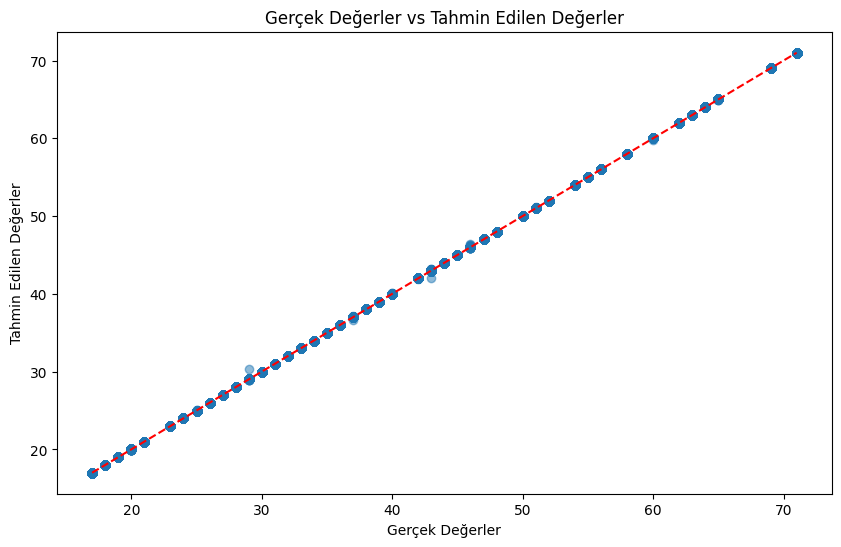

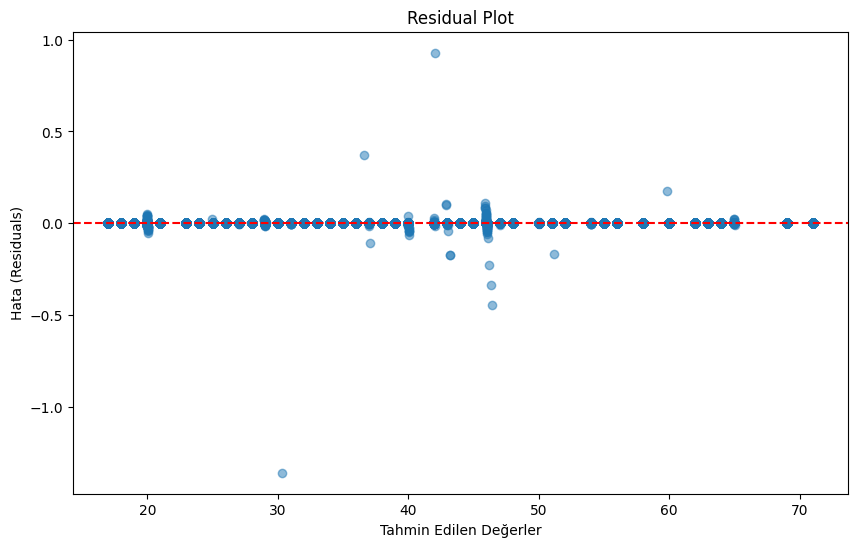

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Tahminler
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

# Hata hesaplamaları
mae_train = mean_absolute_error(y_age_train, y_train_pred)
mae_test = mean_absolute_error(y_age_test, y_test_pred)
mse_train = mean_squared_error(y_age_train, y_train_pred)
mse_test = mean_squared_error(y_age_test, y_test_pred)
r2_train = r2_score(y_age_train, y_train_pred)
r2_test = r2_score(y_age_test, y_test_pred)

# Model performansını ekrana yazdırma
print(f"Train MAE: {mae_train:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Train R^2: {r2_train:.4f}")
print(f"Test R^2: {r2_test:.4f}")

# Gerçek değerler ile tahmin edilen değerler arasında karşılaştırma
plt.figure(figsize=(10, 6))
plt.scatter(y_age_test, y_test_pred, alpha=0.5)
plt.plot([min(y_age_test), max(y_age_test)], [min(y_age_test), max(y_age_test)], color='red', linestyle='--')
plt.title('Gerçek Değerler vs Tahmin Edilen Değerler')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.show()

# Hata dağılımı (Residual Plot)
residuals = y_age_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Tahmin Edilen Değerler')
plt.ylabel('Hata (Residuals)')
plt.show()

# Learning Curve görselleştirmesi kaldırıldı


In [8]:
# Model 2: cuML Logistic Regression (Cinsiyet tahmini)
cuml_logistic_classifier = cuMLLogisticRegression(max_iter=1000)
try:
    cuml_logistic_classifier.fit(X_train_scaled, y_gender_train)
    y_gender_pred = cuml_logistic_classifier.predict(X_test_scaled)
    print(f"Accuracy Score (cuML Logistic Regression): {accuracy_score(y_gender_test, y_gender_pred)}")
except Exception as e:
    print(f"Error training cuML Logistic Regression model: {e}")

Accuracy Score (cuML Logistic Regression): 1.0


In [9]:
# Modeli kaydet
joblib.dump(cuml_logistic_classifier, 'cuml_logistic_model_3.pkl')
print("Model successfully saved as 'cuml_logistic_model_3.pkl'")


Model successfully saved as 'cuml_logistic_model_3.pkl'


Accuracy Score (cuML Logistic Regression): 1.0000


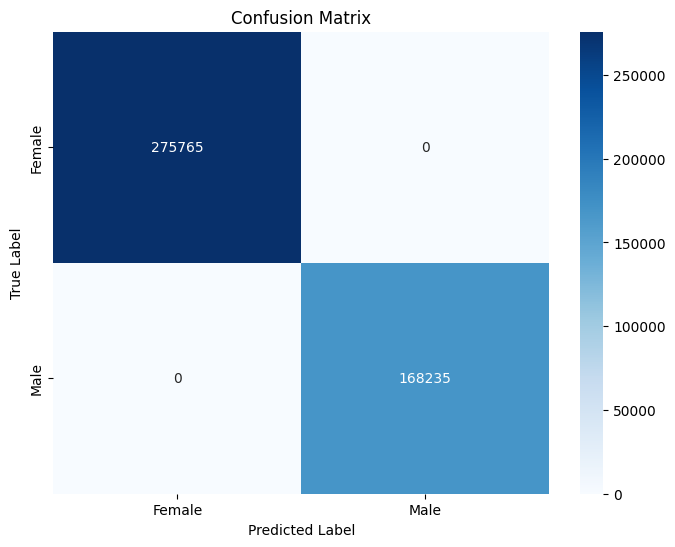

Classification Report:
               precision    recall  f1-score   support

      Female       1.00      1.00      1.00    275765
        Male       1.00      1.00      1.00    168235

    accuracy                           1.00    444000
   macro avg       1.00      1.00      1.00    444000
weighted avg       1.00      1.00      1.00    444000



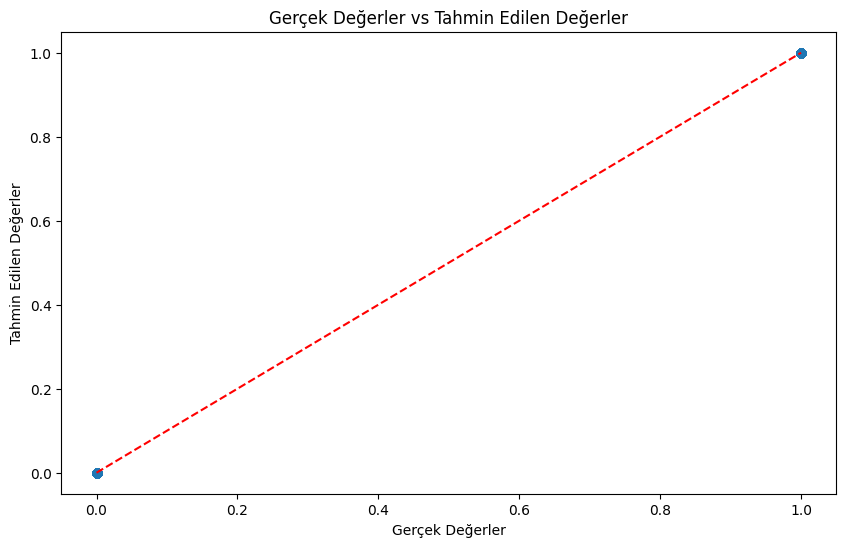

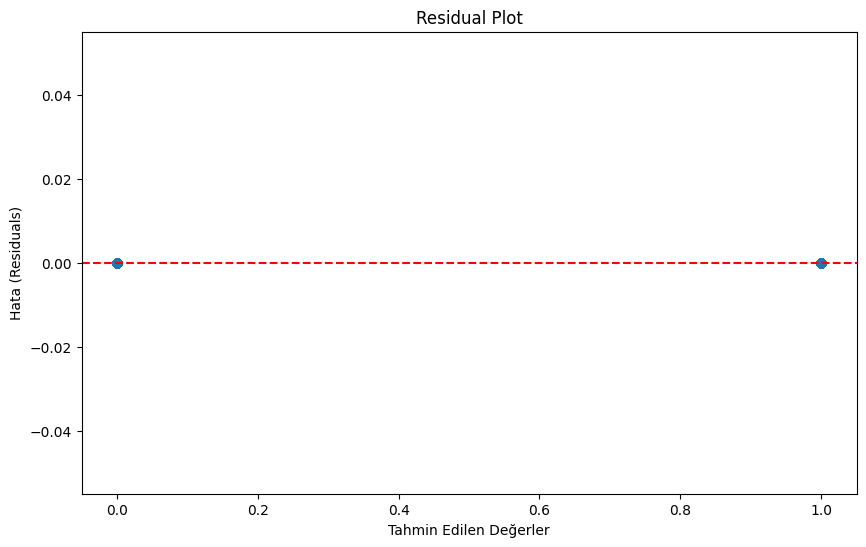

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Tahminler
y_gender_pred = cuml_logistic_classifier.predict(X_test_scaled)

# Accuracy Score
accuracy = accuracy_score(y_gender_test, y_gender_pred)
print(f"Accuracy Score (cuML Logistic Regression): {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_gender_test, y_gender_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
report = classification_report(y_gender_test, y_gender_pred, target_names=['Female', 'Male'])
print("Classification Report:\n", report)

# Gerçek ve tahmin edilen değerler karşılaştırması
plt.figure(figsize=(10, 6))
plt.scatter(y_gender_test, y_gender_pred, alpha=0.5)
plt.plot([min(y_gender_test), max(y_gender_test)], [min(y_gender_test), max(y_gender_test)], color='red', linestyle='--')
plt.title('Gerçek Değerler vs Tahmin Edilen Değerler')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.show()

# Hata Dağılımı
residuals = y_gender_test - y_gender_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_gender_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Tahmin Edilen Değerler')
plt.ylabel('Hata (Residuals)')
plt.show()


Accuracy Score (sklearn RandomForestClassifier): 1.0


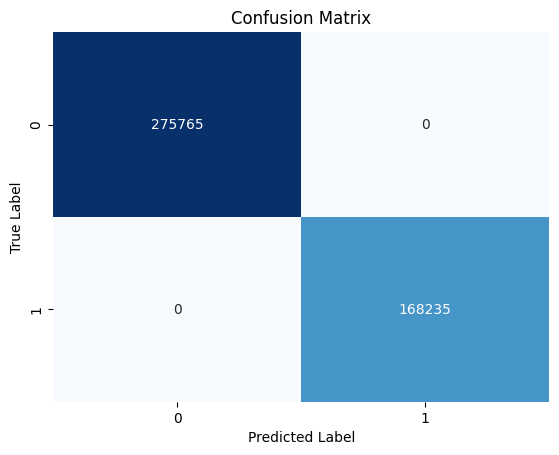


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    275765
           1       1.00      1.00      1.00    168235

    accuracy                           1.00    444000
   macro avg       1.00      1.00      1.00    444000
weighted avg       1.00      1.00      1.00    444000

Model saved as 'gender_rf_classifier.pkl'


In [35]:
from sklearn.ensemble import RandomForestClassifier  # Bu satır eksik olabilir
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# RandomForestClassifier modelini tanımla
sklearn_rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)

try:
    # Modeli eğit
    sklearn_rf_classifier.fit(X_train_scaled, y_gender_train)
    
    # Test verisi üzerinde tahmin yap
    y_gender_pred = sklearn_rf_classifier.predict(X_test_scaled)
    
    # Doğruluk oranını hesapla ve yazdır
    accuracy = accuracy_score(y_gender_test, y_gender_pred)
    print(f"Accuracy Score (sklearn RandomForestClassifier): {accuracy}")
    
    # Karışıklık matrisi (Confusion Matrix) çizimi
    cm = confusion_matrix(y_gender_test, y_gender_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Sınıflandırma raporunu yazdır
    print("\nClassification Report:\n")
    print(classification_report(y_gender_test, y_gender_pred))

    # Modeli kaydet
    joblib.dump(sklearn_rf_classifier, 'gender_rf_classifier.pkl')
    print("Model saved as 'gender_rf_classifier.pkl'")
    
except Exception as e:
    print(f"Error training sklearn RandomForestClassifier model: {e}")


In [39]:
import numpy as np
import pandas as pd
import joblib

# Modelleri yükleme
xgb_regressor = joblib.load('/kaggle/working/xgb_regressor_model_3.pkl')
cuml_logistic_classifier = joblib.load('/kaggle/working/gender_rf_classifier.pkl')

# Standartlaştırıcıyı (Scaler) yükleme
scaler = joblib.load('/kaggle/working/scaler_3.pkl')

# Özellik isimlerini belirleme (Scikit-learn fit sırasında bu isimleri kullandı)
feature_names = scaler.feature_names_in_

# Kullanıcıdan gelen veriyi DataFrame'e çevirme
user_input = pd.DataFrame([[
-1347.7554821471945,-1229.0140858511422,-6291.528255695342,1890.8732089552238,-4180.906804635762,1542.756346703166,-481.57521585322826,-12738.380235294118,-4016.0980537367354,-701.827604306864,4758.902939569819,50.70819403808997,4000.927123039807,1280.8372839506173,-4216.310502741285,-2909.5968047882134,15.098264923851888,-1390.5954971240758,-869.5607101319616,588.5193007511648,1848.575661163648,16487.076624737947,-628.8150299255246,-2576.338667601683,5518.697106411548,-566.4762272899858,1850.9474598349977,3344.423037974684,1768.9638223655284,-3147.6320077681507,2517.270870191319,9373.08266119578,-3459.840253807107,-6996.778777330768,5745.798542665389,-4809.297932525952,-6512.035657075551,3046.3883248543148,1018.0738325253416,-7581.961381165919,-8490.582303262958,-9161.168674317372,-2959.323244243041,828.0695769392474,1574.288700992937,11089.462265163715,4207.68918938137,5840.37990036452,2144.450914463452,4247.258033419023,902.0936050615525,-5026.899774751179,-2576.2543242595034,2912.8094941030413,-3022.6211417125687,7517.072350020687,92.61197838339483,-6814.172801439712,-2475.850572797809,5972.483136976579,-3156.49043339254,6108.391910805571,-3221.132714655375,3472.0227580128203
]], columns=feature_names)

# Veriyi standartlaştırma
user_input_scaled = scaler.transform(user_input)

# Yaş tahmini yap ve tam sayıya yuvarla
predicted_age = xgb_regressor.predict(user_input_scaled)
predicted_age_rounded = round(predicted_age[0])
print(f"Tahmin Edilen Yaş: {predicted_age_rounded}")

# Cinsiyet tahmini yap
predicted_gender = cuml_logistic_classifier.predict(user_input_scaled)
predicted_gender_label = "Erkek" if predicted_gender[0] == 1 else "Kadın"
print(f"Tahmin Edilen Cinsiyet: {predicted_gender_label}")


Tahmin Edilen Yaş: 29
Tahmin Edilen Cinsiyet: Erkek


In [36]:
import numpy as np
import pandas as pd
import joblib

# Modelleri yükleme
xgb_regressor = joblib.load('/kaggle/input/modeller/scikitlearn/default/1/xgb_regressor_model_2.pkl')
cuml_logistic_classifier = joblib.load('/kaggle/working/gender_rf_classifier.pkl')

# Standartlaştırıcıyı (Scaler) yükleme
scaler = joblib.load('/kaggle/input/modeller/scikitlearn/default/1/scaler.pkl')

# Özellik isimlerini belirleme (Scikit-learn fit sırasında bu isimleri kullandı)
feature_names = scaler.feature_names_in_

# Kullanıcıdan gelen veriyi DataFrame'e çevirme
user_input = pd.DataFrame([[
-1347.7554821471945,-1229.0140858511422,-6291.528255695342,1890.8732089552238,-4180.906804635762,1542.756346703166,-481.57521585322826,-12738.380235294118,-4016.0980537367354,-701.827604306864,4758.902939569819,50.70819403808997,4000.927123039807,1280.8372839506173,-4216.310502741285,-2909.5968047882134,15.098264923851888,-1390.5954971240758,-869.5607101319616,588.5193007511648,1848.575661163648,16487.076624737947,-628.8150299255246,-2576.338667601683,5518.697106411548,-566.4762272899858,1850.9474598349977,3344.423037974684,1768.9638223655284,-3147.6320077681507,2517.270870191319,9373.08266119578,-3459.840253807107,-6996.778777330768,5745.798542665389,-4809.297932525952,-6512.035657075551,3046.3883248543148,1018.0738325253416,-7581.961381165919,-8490.582303262958,-9161.168674317372,-2959.323244243041,828.0695769392474,1574.288700992937,11089.462265163715,4207.68918938137,5840.37990036452,2144.450914463452,4247.258033419023,902.0936050615525,-5026.899774751179,-2576.2543242595034,2912.8094941030413,-3022.6211417125687,7517.072350020687,92.61197838339483,-6814.172801439712,-2475.850572797809,5972.483136976579,-3156.49043339254,6108.391910805571,-3221.132714655375,3472.0227580128203
]], columns=feature_names)

# Veriyi standartlaştırma
user_input_scaled = scaler.transform(user_input)

# Yaş tahmini yap ve tam sayıya yuvarla
predicted_age = xgb_regressor.predict(user_input_scaled)
predicted_age_rounded = round(predicted_age[0])
print(f"Tahmin Edilen Yaş: {predicted_age_rounded}")

# Cinsiyet tahmini yap
predicted_gender = cuml_logistic_classifier.predict(user_input_scaled)
predicted_gender_label = "Erkek" if predicted_gender[0] == 1 else "Kadın"
print(f"Tahmin Edilen Cinsiyet: {predicted_gender_label}")


Tahmin Edilen Yaş: 29
Tahmin Edilen Cinsiyet: Erkek
